# Basics

In [1]:
!pip install nbdev

Defaulting to user installation because normal site-packages is not writeable


In [2]:
# hide
import sys
sys.path.append("..")
from nbdev.showdoc import *

In [3]:
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable


In [5]:
pip install python-dateutil==2.8.2

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [6]:
! pip install fastai

Defaulting to user installation because normal site-packages is not writeable


In [4]:
! pip install SimpleITK

Defaulting to user installation because normal site-packages is not writeable


In [5]:
# export
# default_exp basics
import tempfile
import os
import pickle

import torchvision
from fastai.basics import *

# for DICOM support
import SimpleITK as sitk

# for video support
# depends on: https://github.com/PyAV-Org/PyAV#installation
from torchvision.io import video

## Why a new class?
Fastai 2 provides support to read and display medical images using pydicom and pillow; however, only 2D images can be read. Therefore, no direct support of 3D volumes is provided by fastai. Furthermore, fastai only allows to read DICOM 2D images, not volumes, DICOM series or any of the other medical formats such as NIfTI, NRRD etc. For effective work with medical data, all possible formats should be supported. Therefore, in `faimed3d`, [SimpleITK](https://simpleitk.org/)  is used to read images. SimpleITK is a powerfull library which can handle many data formats, including all of the above mentioned and many more. It is widely used for medical applications and very fast, as it is written in pure C++.  
To allow specific augmentations, only to 3D data, two new classes are used in `faimed3d`: `TensorDicom3D` for 3D image volumes and `TensorMask3D` for segmentation masks. Both are subclasses to `torch.Tensor`. A basic support for header information will be implemented in both classes, as the header sometimes has important information, e.g. for re-scaling of the pixel values, pixel spacing or patient orientation. 


## Reading medical files with TensorDicom3D

In [6]:
# export
class TensorDicom3D(TensorBase):
    "Base class for 3D medical images"

    def __init__(self, data, metadata=None, **kwargs):
        super().__init__(**kwargs)
        if metadata is None:
            metadata =  {'0008|103E': ['faimed3d TensorDicom3D, pixeldata might have been modified'],
                         'filename': [''],
                         'spacing' : (1,1,1),
                         'origin' : (0,0,0),
                         'direction' : (1,0,0, 0,1,0, 0,0,1)
                        }
        self._metadata =  metadata


    def __new__(cls, x, metadata=None, *args, **kwargs):
        res = cast(tensor(x), cls)
        for k,v in kwargs.items(): setattr(res, k, v)
        return res

    @classmethod
    def create(cls, fn:(Path,str,Tensor,ndarray), load_header=True,  **kwargs):
        """
        Open an `3D Image` from path `fn` or create it from an array
        Args:
            cls: Class of the object to create. Should be either TensorDicom3D or TensorMask3D
            fn:  Filename of the medical image file. String or `pathlib.Path`
        Returns:
            An instance of `cls`
        """
        if isinstance(fn, Path): fn = str(fn)
        if isinstance(fn, str):
            if fn.endswith('.npy'): fn = np.float32(np.load(fn))
            elif fn.endswith(('.avi','.mpg','.mpeg', '.mp4')):
                fn, _, _ = video.read_video(fn)         ## read video frames into tensor
                fn = fn.type(torch.FloatTensor)         ## convert from ByteTensor to FloatTensor
                fn = fn.permute(3,0,1,2)                ## permute tensor to expected shape
            else:
                array, metadata = TensorDicom3D.load(fn,load_header)
                instance = cls(array, metadata)
        if isinstance(fn, sitk.Image): instance = cls(*TensorDicom3D.from_sitk(fn))
        if isinstance(fn, ndarray): instance = cls(fn)
        if isinstance(fn, Tensor): instance = cls(fn)
        return instance

    @staticmethod
    def from_sitk(im):
        metadata = {'0008|103E': ['faimed3d TensorDicom3D, pixeldata might have been modified'],
                    'filename' : []}
        for k in im.GetMetaDataKeys():
                    metadata[k] = im.GetMetaData(k).encode(encoding='UTF-8',errors='ignore').decode()
        return torch.tensor(sitk.GetArrayFromImage(im)), metadata


    @staticmethod
    def load(fn: (Path, str), load_header:bool):
        """
        Loads a Medical image file. Stores pixel information as `Tensor` and DICOM header as dictionary.
        Args:
            fn:  Filename of the medical image file. String or `pathlib.Path`
            metadata_for_all_slices: if a DICOM series is given, if metadata from every single elemt of the series should be read.

        Returns:
            A tuple. 1st element is the pixelvalues converted to a `Tensor`, 2nd element is the metadata as dict.
        Process:
           [load pixel array] -> [load basic metadata] -> [load image header] -> [return]

            load pixel array:
                Medical images can be presented as a single volumetric file or as a (DICOM)-series.
                If `fn` points to a directory, it is assumed that a DICOM series should be loaded.
                If `fn` is a file, it is assumed it is a single 3D Volume.

            load basic meta data:
                Spacing, origin and direction are important for image display and calulations.
                They are stored seperatly.

            load image header (optional):
                creates a dict with header information.
                For multiple slices, header information for each slice is loaded.

                | tags      | fn_01                        | fn_02             | ...
                |-----------|------------------------------|-------------------|----
                | DICOM tag | name of file or of 1st slice | name of 2nd slice | ...

                Some tags contain special characters, which are transformed to surrogates.
                This will lead to failure when displaying or writing the metadata.
                Using encode(errors='ignore').decode() the surrogates are removed and the string ist turned into a bytes object.
                Using decode will turn the bytes back into a string.
        """
        # initialize metadata
        metadata = {'0008|103E': ['faimed3d TensorDicom3D, pixeldata might have been modified'],
                    'filename' : [str(fn)]}


        # read volume
        if isinstance(fn, str): fn = Path(fn)
        if fn.is_dir():
            sitk.ProcessObject_SetGlobalDefaultThreader('PLATFORM')
            im = TensorDicom3D.read_dicom_series(str(fn))
        elif fn.is_file(): im = sitk.ReadImage(str(fn), outputPixelType=sitk.sitkFloat32)
        else: raise TypeError('the path "{}" is neither a valid directory nor a file'.format(str(fn)))
        # set basic metadata
        metadata['spacing'] = im.GetSpacing()
        metadata['origin'] = im.GetOrigin()
        metadata['direction'] = im.GetDirection()
        if load_header:
            if fn.is_dir():
                metadata = TensorDicom3D.read_metadata_from_series(str(fn), metadata)
            if fn.is_file():
                for k in im.GetMetaDataKeys():
                    metadata[k] = im.GetMetaData(k).encode(encoding='UTF-8',errors='ignore').decode()
        return (torch.tensor(sitk.GetArrayFromImage(im)), metadata)

    @staticmethod
    def read_metadata_from_series(fn:str, metadata:dict):
        "read metadata from file or Series and returns a pd.DataFrame"
        # iter through slices, collecting remaining metadata
        SeriesReader = sitk.ImageSeriesReader()
        dicom_names = SeriesReader.GetGDCMSeriesFileNames(str(fn))
        reader = sitk.ImageFileReader()
        reader.SetFileName(dicom_names[0])
        reader.ReadImageInformation()

        for dcm in dicom_names:
            reader.SetFileName(dcm)
            reader.ReadImageInformation()
            for k in reader.GetMetaDataKeys():
                try:
                    val = reader.GetMetaData(k).encode(encoding='UTF-8',errors='ignore').decode()
                    if k not in metadata:  metadata[k] = [val]
                    elif val not in metadata[k]: metadata[k].append(val)
                except:
                    print('Failed loading metadata for {}'.format(fn))

        return metadata

    @staticmethod
    def read_dicom_series(fn:str):
        """load a DICOM series as 3D volume."""
        SeriesReader = sitk.ImageSeriesReader()
        dicom_names = SeriesReader.GetGDCMSeriesFileNames(str(fn))
        SeriesReader.SetFileNames(dicom_names)
        im = SeriesReader.Execute()
        return sitk.Cast(im, sitk.sitkFloat32)

    def as_sitk(self):
        "convertes Tensor to SimpleITK image"
        im = sitk.GetImageFromArray(self.detach().cpu().numpy())
       # also save metadata
        im.SetSpacing(self._metadata['spacing'])
        im.SetDirection(self._metadata['direction'])
        im.SetOrigin(self._metadata['origin'])
        for k in self._metadata:
            try: im.SetMetaData(self._metadata[k][0], k)
            except: pass
        return im

    def save(self, fn:str):
        im = self.as_sitk()
        sitk.WriteImage(im, fn)

    def get_metadata(self, tag): return self._metadata[tag]

    def set_metadata(self, tag, value): self._metadata[tag]=value

    def del_metadata(self, tag): self._metadata.pop(tag)

    def metadata_to_json(self, metadata=None):
        import json
        if metadata is none: metadata = self._metadata
        return json.dumps(metadata, indent = 4)

    def print_metadata(self, full = False):
        for i, k in enumerate(self._metadata.keys()):
            if i < 5: print(k, ': \t', self._metadata[k])
            elif full:
                print(k, ':')
                for i, val in enumerate(self._metadata[k]):
                    print('\t', val)
                    if i == 2:
                        print('\t (...)')
                        break

In [7]:
# export
class TensorMask3D(TensorDicom3D):
    "Base class for 3d Segmentation, inherits from TensorDicom3D"

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

In [8]:
fn = '/home/feczk001/shared/projects/S1067_Loes/data/MNI-space_Loes_data/sub-4750MASZ_ses-20080220_space-MNI_mprageGd.nii.gz'
im = TensorDicom3D.create(fn, load_header=True)

In [9]:
test_eq(hasattr(im, '_metadata'), True)
test_eq(hasattr(im[0], '_metadata'), True)
im2 = im
test_eq(im._metadata, im2._metadata)
test_eq(isinstance(im[im > 3], Tensor), True)
_ = torch.stack((im, im2))

### Handlers for metadata

Some metadata needs to be modified, acessed more than other, so some wrapper functions are supplied. 

In [10]:
# export
@patch
def set_spacing(t:TensorDicom3D, spacing):
    if isinstance(spacing, tuple) and len(spacing) == 3:
        t.set_metadata('spacing', spacing)
    else:  raise ValueError('Spacing must be a tuple of length 3, but got {}'.format(spacing))

@patch
def get_spacing(t:TensorDicom3D): return t.get_metadata('spacing')

@patch
def set_origin(t:TensorDicom3D, origin):
    if isinstance(origin, tuple) and len(origin) == 3:
        t.set_metadata('origin', origin)
    else: raise ValueError('Origin must be a tuple of length 3, but got {}'.format(spacing))

@patch
def get_origin(t:TensorDicom3D): return t.get_metadata('origin')

@patch
def set_direction(t:TensorDicom3D, direction):
    if isinstance(direction, tuple) and len(direction) == 9:
        t.set_metadata('direction', direction)
    else: raise ValueError('Direction must be a tuple of length 3, but got {}'.format(spacing))

@patch
def get_direction(t:TensorDicom3D): return t.get_metadata('direction')

## Display 3D images

Function to display the 3D volume in axial, coronal or sagittal reconstruction. The display functions does not consider the spacing between pixels, so reconstructions may look unusual. 

In [11]:
# export
def show_image_3d(t: (np.ndarray, torch.Tensor),
                  axis: int = 0,
                  figsize: int = (15,15),
                  cmap: str = 'bone',
                  nrow: int = 10,
                  alpha = 1.,
                  return_grid = False,
                  add_to_existing = False,
                  **kwargs):
    '''
    Plots 2D slices of a 3D image alongside a prior specified axis.
    Args:
        t: a 3D numpy.ndarray or torch.Tensor
        axis: axis to split 3D array to 2D images
        figsize, cmap: passed to plt.imshow
        nrow: passed to torchvision.utils.make_grid
        return_grid: Whether the grid should be returned for further processing or if the plot should be displayed.
        add_to_existing: if set to true, no new figure will be created. Used for mask overlays
    '''
    if t.device.type == 'cuda': t=t.cpu()
    if t.ndim < 3 or t.ndim > 4:
         raise TypeError('Object is not a rank 3 tensor but a rank {} tensor'.format(t.ndim ))
    if t.ndim == 4:
        warn('Object is not a rank 3 tensor but a rank {} tensor. Removing the first dimension'.format(t.ndim))
        t = t[0]
    if isinstance(t, np.ndarray): t = tensor(t)
    # TODO: is there a nicer more flexible way to adapt the axis?
    if axis == 1: t = t.permute(1, 0, 2)
    elif axis == 2: t = t.permute(2, 0, 1)

    # TODO: is there a better way to visualize the images?
    if t.min() < 0.: t = t-t.min() # shift pixelvalues to positive range, otherwise the negative values will be clipped.
    t = t.unsqueeze(1)/t.max() # rescale the images, makes for a nicer plot
    grid = torchvision.utils.make_grid(t, nrow = nrow)
    if return_grid: return grid
    if not add_to_existing: plt.figure(figsize=figsize)
    plt.imshow(grid[0,:,:], cmap = cmap, alpha = alpha)

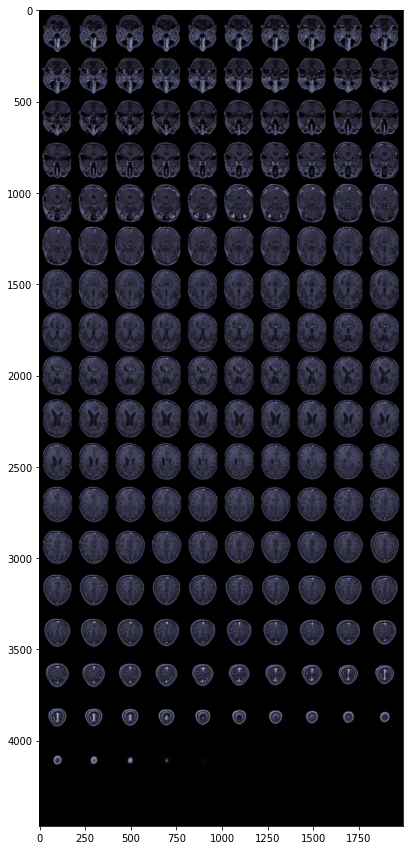

In [12]:
show_image_3d(im, axis = 0, nrow = 10)

Sometimes multiple 3D images (e.g. a batch) need to be displayed. With a wrapper for `show_image_3d` this is possible.  

In [13]:
# export
def show_images_3d(t: torch.Tensor,
                   axis: int = 0,
                   figsize: int = (15,15),
                   cmap: str = 'bone',
                   nrow: int = 10,
                   alpha = 1.,
                   return_grid = False,
                   add_to_existing=False,
                   **kwargs):
    """
    Displays multiple 3D images (e.g. a batch) by flattening the 4th dimension of the tensor
    and then calling show_image_3d
    Args:
        t (torch.Tensor): input image with dimension B x D x H x W or B x C x D x H x W,
                          however C is ignored for display
        axis (int): Axis to split images to multiple 2D slices. `show_images_3d` does not
                    know about pixel spacing, so choosing a non-standard axis will result in
                    atypical looking images.
        figsize, cmap, nrow, alpha: passed to plot function
        return_grid (bool): return the grid, not the plot for further processing
        add_to_existing (bool): adds plot to existing plot, not calling plot.new.
                                Usefull for overlays, e.g. with masks.

    """
    # TO DO: implement pixel spacing and interpolation for view.
    if t.ndim not in (4,5):
        raise TypeError('Object is not a rank 4 or rank 5 tensor but a rank {} tensor'.format(t.ndim))
    if axis > 2:
        raise ValueError('Axis should be between 0-2, indexing the plane to display '
                         'each of the multiple 3D images. But axis was {}'.format(axis))

    if t.ndim == 4: t =t.reshape(t.size(0)*t.size(1), t.size(2), t.size(3))
    if t.ndim == 5:
        t = t.permute(1,0,2,3,4)
        t =t.reshape(t.size(0), t.size(1)*t.size(2), t.size(3), t.size(4))
    if return_grid: return t
    show_image_3d(t, axis = axis, figsize = figsize, cmap = cmap,
                  nrow = nrow, alpha = alpha, add_to_existing = add_to_existing)

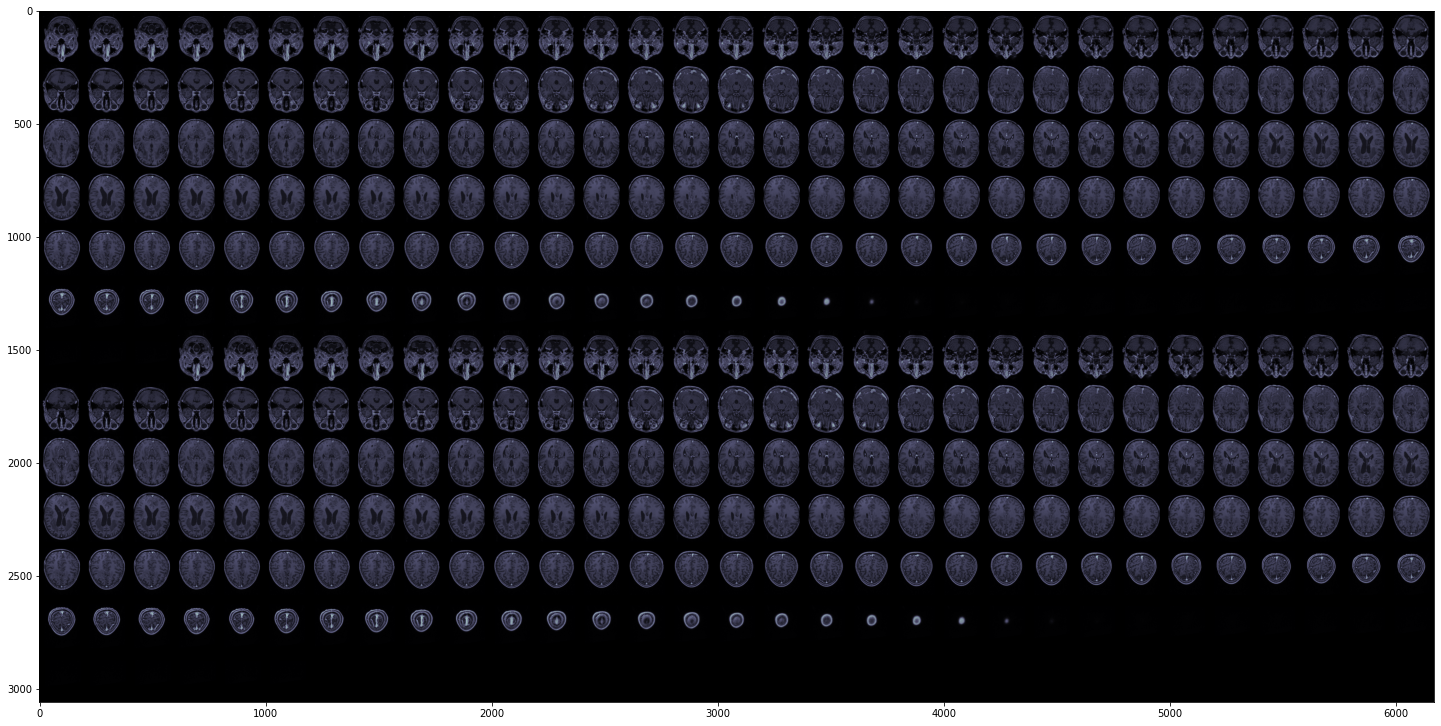

In [14]:
show_images_3d(torch.stack((im,im)), axis = 0, nrow = 31, figsize = (25, 15))

In [15]:
from torch import Tensor # for compatibility with show_docs

In [16]:
# export
@patch
def show(t:TensorDicom3D, axis: int = 0, figsize: int = (15,15), cmap: str = 'bone', nrow: int = 10, **kwargs):
    "displays the 3D image as a mosaik"
    if t.ndim == 3: return show_image_3d(t, axis = axis, figsize=figsize,
                                         cmap=cmap, nrow=nrow, return_grid = False, **kwargs)
    if t.ndim in (4,5): return show_images_3d(t, axis = axis, figsize=figsize,
                                              cmap=cmap, nrow=nrow, return_grid = False, **kwargs)

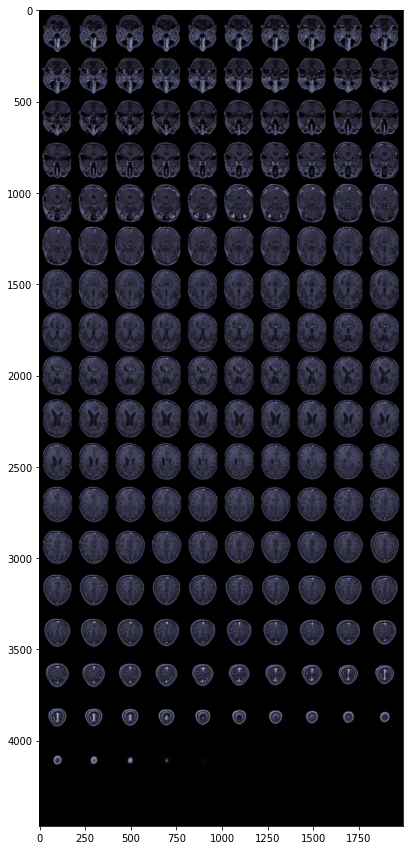

In [17]:
im.show()

# Rendering 3D objects

Somtimes the mask is better viewed as a 3D object. Rendering is implemented as described in this example: https://scikit-image.org/docs/dev/auto_examples/edges/plot_marching_cubes.html
A faster, more flexible way might be using [ipyvolume](https://github.com/maartenbreddels/ipyvolume/) or [vtk](https://pyscience.wordpress.com/2014/09/11/surface-extraction-creating-a-mesh-from-pixel-data-using-python-and-vtk/). 

To implement 3D rendering for the mask, the TensorMask3D class needs to be expanded.

In [18]:
# export
@patch
def _strip_along(x:TensorDicom3D, dim):
    try: meta = x._metadata
    except: pass
    slices = torch.unbind(x, dim)
    slices = [s for s in slices if s.sum() != 0]
    out = torch.stack(slices, dim)
    setattr(out, '_metadata', meta)
    return out

@patch
def strip(x:TensorDicom3D):
    return x._strip_along(-1)._strip_along(-2)._strip_along(-3)

In [19]:
# export
class TensorMask3D(TensorDicom3D):
    "Base class for 3d segmentation, inherits from TensorDicom3D"

    @classmethod
    def create(cls, fn:(Path,str,Tensor,ndarray), load_header=False,  **kwargs):
        instance = super().create(fn=fn, load_header=load_header, **kwargs)
        instance = instance.long()
        return instance

    def create_mesh(self, cl, color, alpha):
        "creates a 3D mesh for a single class in the 3D Tensor"
        if self.ndim != 3: raise NotImplementedError('Currently only rank 3 tensors are supported for rendering')
        from skimage.measure import marching_cubes
        from mpl_toolkits.mplot3d.art3d import Poly3DCollection
        im = (self == cl).float()
        verts, faces, normals, values = marching_cubes(im.permute(1, 2, 0).numpy())
        mesh = Poly3DCollection(verts[faces])
        mesh.set_facecolor(color)
        mesh.set_alpha(alpha)
        return mesh

    def show_center_point(self):
        "displays a cross in the center of the mask"
        z, x, y = self.get_nonzero_bool()
        center_z = self.get_center_id(z)
        center_x = self.get_center_id(x)
        center_y = self.get_center_id(y)
        c_val = im.max()+2
        self[center_z, center_x-50:center_x+50, center_y-5:center_y+5] = c_val
        self[center_z, center_x-5:center_x+5, center_y-50:center_y+50] = c_val
        self.show()

    def create_mesh_for_classes(self, colors, alpha):
        "applies `create_mesh` to all classes of the mask"
        classes = self.unique()[1:]
        if colors is None: colors = 'bgrcmyw'
        if len(classes) > len(colors):
            colors = random.choices(colors, k=len(classes))
        else:
            colors = colors[0:len(classes)]
        if alpha is None: alpha = (0.5, )*len(classes)
        if type(alpha) is not tuple: raise TypeError('alpha need to be a tuple.')
        if len(alpha) == 1: alpha = alpha*len(classes)
        if len(alpha) != len(classes):
            raise ValueError('Number of classes and number of alpha does not match')
        cca = list(zip(classes, colors, alpha))
        meshes = [self.create_mesh(cl=cl, color=color, alpha=alpha) for cl, color, alpha in cca]
        return meshes

    def render_3d(self, colors=None, alpha = None, symmetric=False):
        "renders the mask as a 3D object and displays it"

        im = self.strip()
        meshes = im.create_mesh_for_classes(colors = colors, alpha = alpha)
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')
        for m in meshes: ax.add_collection3d(m)
        ax.set_xlim(0, im.size(1))
        ax.set_ylim(0, im.size(2))
        ax.set_zlim(0, im.size(0))
        ax.set_facecolor('k')
        plt.axis('off')
        plt.tight_layout()
        plt.show()

    def calc_volume(self):
        """
        Calculates the volume for a single class in the mask.
        Calculation relies on correct spacing information in the header.
        Results are given in mm**3
        """
        x,y,z = self._metadata['spacing']
        voxel_size = x*y*z
        self.volume = {'background': self._calc_vol_per_class(0, voxel_size)}
        self.volume['total_mask_volume'] = self.size(0)*self.size(1)*self.size(2)*voxel_size - self.volume['background']
        for c in self.unique()[1:]:
            name = 'class '+str(int(c))
            self.volume[name] = self._calc_vol_per_class(c, voxel_size)
        print(self.volume)

    def _calc_vol_per_class(self, class_idx, voxel_size):
        "calculates volume of the void, whole mask and for each class in the mask"
        return float((self == class_idx).sum() * voxel_size)

In [20]:
! pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable


In [21]:
import skimage

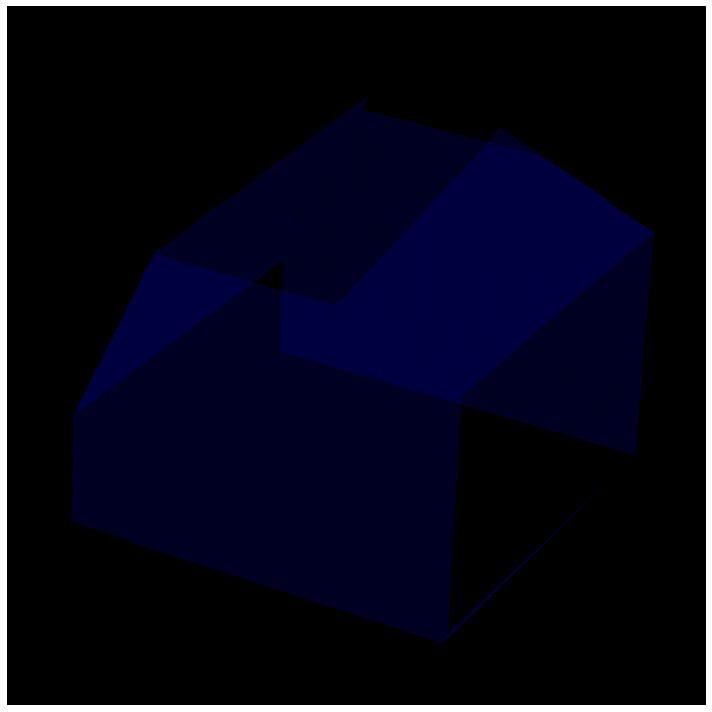

In [22]:
im  = TensorMask3D.create('/home/feczk001/shared/projects/S1067_Loes/data/MNI-space_Loes_data/masks/sub-4750MASZ_ses-20080220_space-MNI_mprageGd.nii.gz')       
im.render_3d(alpha = (0.15,))

In [23]:
im.calc_volume()

{'background': 2432304.0, 'total_mask_volume': 6242985.0, 'class 1': 6242985.0}
